In [1]:
import os
import sys
from multiprocessing import Pool

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import END_OF_POST_TOKEN, PATH_INTERIM_CORPUS  # noqa: E402
from src.features.build_features import get_corpus_id2word  # noqa: E402

In [2]:
# The gambling corpus was introduced for the first time in the previous
# edition of eRisk, thus we only have documents of the testing phase.
CORPUS_KIND = "xml"
CORPUS_NAME = "gambling"
NUM_SUB_PROCESSES = int(2 * os.cpu_count() / 3)

## Generate a DataFrame for the testing corpus

In [3]:
input_file_path_test = os.path.join(
    PATH_INTERIM_CORPUS, CORPUS_KIND, CORPUS_NAME, f"{CORPUS_NAME}-test-clean.txt"
)

In [4]:
labels = []
documents = []
with open(input_file_path_test) as f:
    for line in f:
        label, document = line.split(maxsplit=1)
        labels.append(label)
        posts = document.split(END_OF_POST_TOKEN)
        documents.append(posts)
df_test = pd.DataFrame({"label": labels, "posts": documents})

## Define functions to obtain interesting features from the documents

In [5]:
TextBlob(df_test.posts[0][0]).sentiment

Sentiment(polarity=-0.0032828282828282892, subjectivity=0.3164862914862915)

In [6]:
def get_num_tokens(posts_list):
    return [len(post.split()) for post in posts_list]


def get_num_tokens_first_person(posts_list):
    return [
        sum(1 if word == "i" else 0 for word in post.split()) for post in posts_list
    ]


def get_polarity(posts_list):
    return [round(TextBlob(post).sentiment.polarity, 2) for post in posts_list]


def get_subjectivity(posts_list):
    return [round(TextBlob(post).sentiment.subjectivity, 2) for post in posts_list]

## Apply functions to the testing corpus

In [7]:
df_test["num_tokens"] = df_test.posts.apply(get_num_tokens)
df_test["num_tokens_first_person"] = df_test.posts.apply(get_num_tokens_first_person)
df_test["polarity"] = df_test.posts.apply(get_polarity)
df_test["subjectivity"] = df_test.posts.apply(get_subjectivity)

In [8]:
df_test

,label,posts,num_tokens,num_tokens_first_person,polarity,subjectivity
0,positive,[sports betting 45k in debt feeling very depre...,"[234, 93, 25, 27, 118, 74, 28, 5, 28, 6, 31, 3...","[12, 2, 1, 2, 5, 5, 2, 0, 1, 0, 2, 3, 3, 1, 2,...","[-0.0, 0.03, 0.0, 0.19, -0.22, -0.18, 0.2, 0.5...","[0.32, 0.38, 0.0, 0.63, 0.37, 0.52, 0.9, 0.65,..."
1,positive,[number with low self esteem honest opinions p...,"[8, 19, 8, 44, 14, 12, 17, 22, 113, 13, 29, 59]","[0, 1, 0, 4, 1, 0, 1, 2, 6, 0, 1, 1]","[0.3, 0.43, 0.8, 0.25, 0.25, 0.5, 0.25, 0.5, 0...","[0.6, 0.6, 0.7, 0.42, 0.33, 0.83, 0.33, 0.5, 0..."
2,positive,[if you can stop now you will be ahead in the ...,"[98, 13, 227, 244, 11, 5, 16, 2, 3, 2, 238, 17...","[4, 1, 7, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...","[0.06, 0.25, 0.23, 0.2, 0.7, 0.0, 0.0, 0.8, 0....","[0.41, 0.5, 0.5, 0.52, 0.6, 0.0, 0.07, 0.75, 1..."
3,positive,"[another day healthier, congratulations, nice ...","[3, 1, 8, 18, 11, 6, 2, 10, 211, 5, 16, 40, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 4, 0, 2, ...","[0.0, 0.0, 0.31, 0.25, 0.0, -0.17, 0.8, 0.43, ...","[0.0, 0.0, 0.49, 0.25, 0.0, 0.43, 1.0, 0.49, 0..."
4,positive,[day number online gambling has destroyed me i...,"[31, 4, 46, 54, 75, 26, 118, 33, 5, 105, 59, 2...","[3, 0, 3, 2, 4, 0, 8, 2, 0, 7, 2, 0, 6, 3, 13,...","[0.09, -0.31, 0.18, 0.07, 0.18, 0.0, 0.02, 0.1...","[0.26, 0.69, 0.61, 0.47, 0.5, 0.0, 0.49, 0.33,..."
...,...,...,...,...,...,...
2343,negative,"[it comes from nuts wink, when it's summer in ...","[5, 22, 19, 4, 40, 22, 229, 38, 17, 23, 52, 18...","[0, 1, 0, 0, 0, 0, 17, 3, 0, 1, 4, 0, 0, 0, 0,...","[0.0, -0.31, 0.0, 0.0, 0.0, -0.26, -0.03, 0.07...","[0.0, 0.69, 0.0, 0.0, 0.5, 0.54, 0.45, 0.47, 0..."
2344,negative,[there's a terminal at work for us to run cred...,"[43, 32, 26, 8, 12, 22, 48, 3, 10, 23, 18, 12,...","[1, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 1, 0, ...","[-0.15, 0.05, 0.0, -0.7, 0.0, 0.01, 0.03, 0.0,...","[0.32, 0.25, 0.0, 1.0, 0.0, 0.72, 0.33, 0.0, 0..."
2345,negative,"[anyone having this scene link, not working, a...","[5, 2, 10, 10, 5, 2, 2, 2, 7, 2, 6, 2, 2, 1, 4...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, -0.17, 0.0, 0.0, 0.6, 0.0, 1.0...","[0.0, 0.0, 0.0, 0.31, 0.0, 0.0, 0.95, 0.0, 1.0..."
2346,negative,[what the rocket league community achieved sin...,"[12, 8, 11, 5, 6, 3, 10, 2, 9, 7, 9, 12, 23, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, -0.5, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Compare the datasets

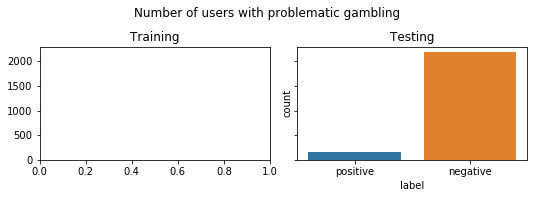

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 3))
ax1.set_title("Training")
ax2.set_title("Testing")
fig.suptitle("Number of users with problematic gambling")
sns.countplot(x="label", data=df_test, ax=ax2)
plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

No handles with labels found to put in legend.
No handles with labels found to put in legend.


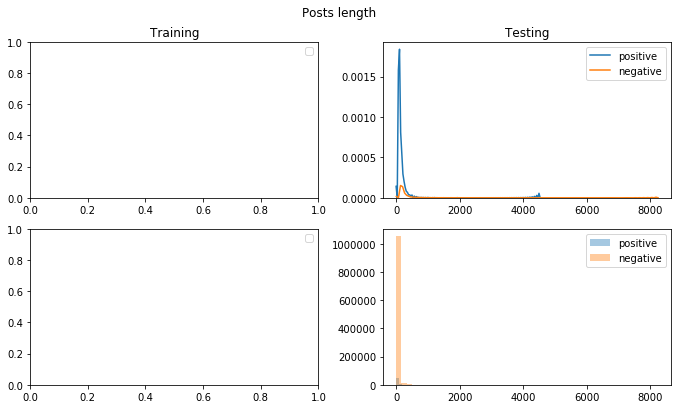

In [10]:
num_tokens_test = df_test.groupby("label").agg({"num_tokens": sum})
num_tokens_test = num_tokens_test.num_tokens.apply(lambda x: np.array(x))
num_tokens_test.apply(lambda x: x.sort())

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))

axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Posts length")

sns.kdeplot(num_tokens_test["positive"], ax=axis[0, 1], label="positive")
sns.kdeplot(num_tokens_test["negative"], ax=axis[0, 1], label="negative")

sns.distplot(num_tokens_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.distplot(num_tokens_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

No handles with labels found to put in legend.
No handles with labels found to put in legend.


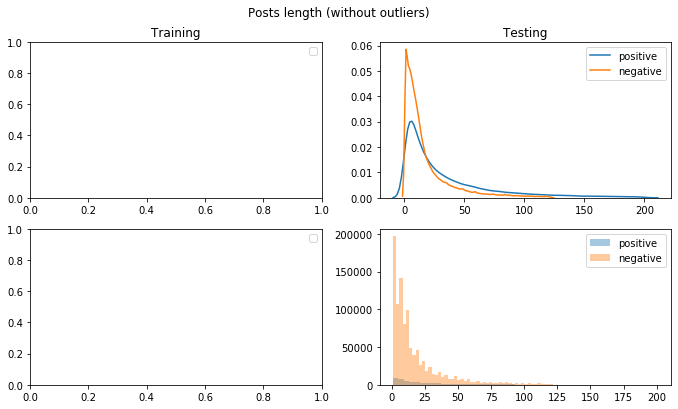

In [11]:
outlier_test_negative, outlier_test_positive = (
    np.quantile(num_tokens_test[0], 0.97),
    np.quantile(num_tokens_test[1], 0.97),
)

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Posts length (without outliers)")

without_outliers = num_tokens_test["positive"][
    num_tokens_test["positive"] < outlier_test_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="positive")
sns.distplot(without_outliers, ax=axis[1, 1], label="positive", kde=False)

without_outliers = num_tokens_test["negative"][
    num_tokens_test["negative"] < outlier_test_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="negative")
sns.distplot(without_outliers, ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

No handles with labels found to put in legend.
No handles with labels found to put in legend.


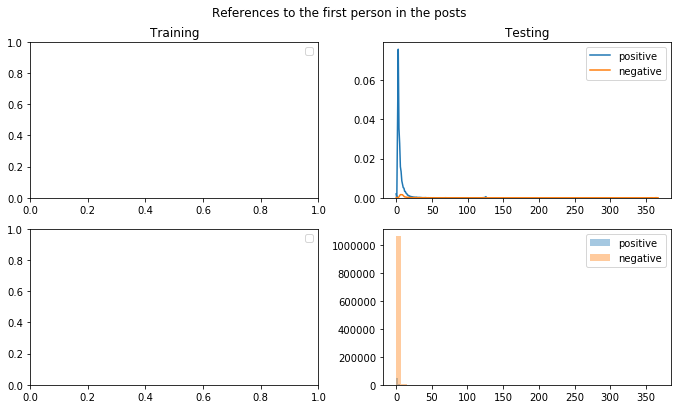

In [12]:
num_first_person_test = df_test.groupby("label").agg({"num_tokens_first_person": sum})
num_first_person_test = num_first_person_test.num_tokens_first_person.apply(
    lambda x: np.array(x)
)
num_first_person_test.apply(lambda x: x.sort())

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("References to the first person in the posts")

sns.kdeplot(num_first_person_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(
    num_first_person_test["positive"], ax=axis[1, 1], label="positive", kde=False
)
sns.kdeplot(num_first_person_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(
    num_first_person_test["negative"], ax=axis[1, 1], label="negative", kde=False
)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

No handles with labels found to put in legend.
No handles with labels found to put in legend.


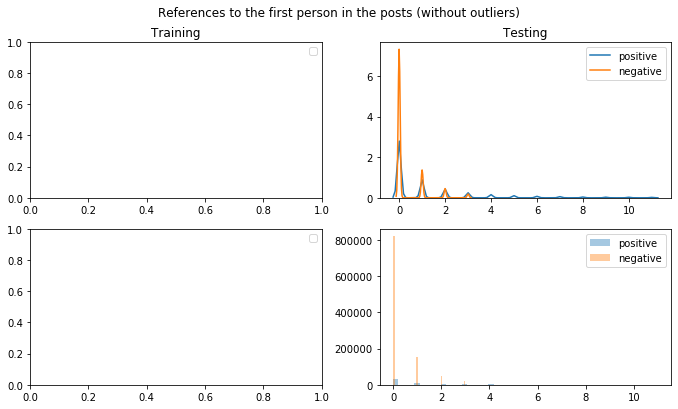

In [13]:
outlier_threshold = 0.98
outlier_test_negative, outlier_test_positive = (
    np.quantile(num_first_person_test[0], outlier_threshold),
    np.quantile(num_first_person_test[1], outlier_threshold),
)

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("References to the first person in the posts (without outliers)")

without_outliers = num_first_person_test["positive"][
    num_first_person_test["positive"] < outlier_test_positive
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="positive")
sns.distplot(without_outliers, ax=axis[1, 1], label="positive", kde=False)

without_outliers = num_first_person_test["negative"][
    num_first_person_test["negative"] < outlier_test_negative
]
sns.kdeplot(without_outliers, ax=axis[0, 1], label="negative")
sns.distplot(without_outliers, ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

## Latent Dirichlet Allocation (LDA)
We apply LDA to obtain the most relevant topics from documents of both positive and negative people for gambling problems.

In [14]:
posts_test = []
for user_posts in df_test.posts:
    aux_list_posts = []
    for post in user_posts:
        for word in post.split():
            aux_list_posts.append(word)
    posts_test.append(aux_list_posts)

In [15]:
posts_test[0][:10]

['sports',
 'betting',
 '45k',
 'in',
 'debt',
 'feeling',
 'very',
 'depressed',
 'i',
 'am']

In [16]:
corpus, id2word, bigram = get_corpus_id2word(posts_test)

In [17]:
lda_test = gensim.models.LdaModel(
    corpus=corpus,
    num_topics=15,
    id2word=id2word,
    chunksize=100,
    passes=50,
    eval_every=1,
    random_state=30,
    per_word_topics=True,
)

In [18]:
lda_test.print_topics(num_topics=-1, num_words=20)

[(0,
  '0.128*"been_removed" + 0.109*"any_questions" + 0.085*"post_has" + 0.049*"unfortunately_your" + 0.029*"our_rules" + 0.028*"please_check" + 0.027*"sign_up" + 0.027*"moderators" + 0.023*"ufc" + 0.022*"submission" + 0.019*"meme" + 0.018*"costa_rica" + 0.018*"image" + 0.018*"text" + 0.015*"make_sure" + 0.014*"hasn\'t_been" + 0.014*"title" + 0.013*"khabib" + 0.013*"check" + 0.012*"receive"'),
 (1,
  '0.008*"games" + 0.008*"team" + 0.007*"players" + 0.005*"playing" + 0.005*"vs" + 0.005*"player" + 0.005*"season" + 0.004*"level" + 0.004*"build" + 0.004*"damage" + 0.004*"played" + 0.003*"against" + 0.003*"match" + 0.003*"win" + 0.003*"fight" + 0.003*"top" + 0.003*"card" + 0.002*"character" + 0.002*"fun" + 0.002*"league"'),
 (2,
  '0.119*"ne" + 0.118*"u" + 0.045*"ve" + 0.041*"bir" + 0.035*"da" + 0.032*"pm" + 0.030*"bu" + 0.026*"sen" + 0.019*"ama" + 0.017*"ben" + 0.017*"ki" + 0.016*"o" + 0.015*"bi" + 0.015*"iin" + 0.013*"ali" + 0.013*"mi" + 0.012*"var" + 0.012*"m" + 0.011*"kan" + 0.010*"gi

In [19]:
top_topics_test = lda_test.get_document_topics(corpus[1], minimum_probability=0.0)
topic_vec_test = [top_topics_test[i][1] for i in range(10)]
top_topics_test, topic_vec_test

([(0, 0.00053857244),
  (1, 0.0005385735),
  (2, 0.0005385731),
  (3, 0.1536903),
  (4, 0.16661024),
  (5, 0.00053857255),
  (6, 0.0005385736),
  (7, 0.025800971),
  (8, 0.0005385725),
  (9, 0.04507213),
  (10, 0.15377428),
  (11, 0.0005385736),
  (12, 0.000538573),
  (13, 0.20658891),
  (14, 0.24415457)],
 [0.00053857244,
  0.0005385735,
  0.0005385731,
  0.1536903,
  0.16661024,
  0.00053857255,
  0.0005385736,
  0.025800971,
  0.0005385725,
  0.04507213])

## Graphs related to the posts sentiment analysis

No handles with labels found to put in legend.
No handles with labels found to put in legend.


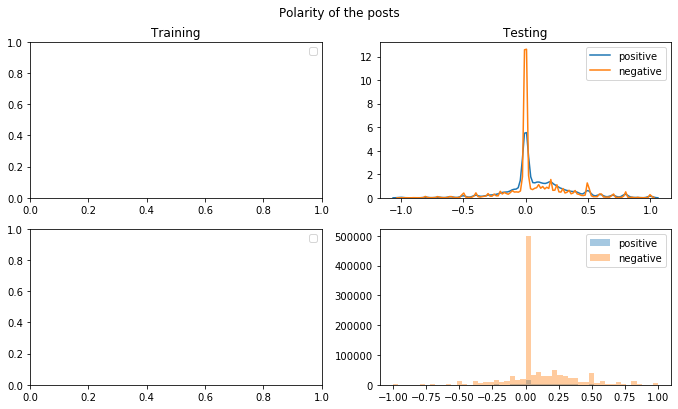

In [20]:
polarity_test = df_test.groupby("label").agg({"polarity": sum})
polarity_test = polarity_test.polarity.apply(lambda x: np.array(x))

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Polarity of the posts")

sns.kdeplot(polarity_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(polarity_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(polarity_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(polarity_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

No handles with labels found to put in legend.
No handles with labels found to put in legend.


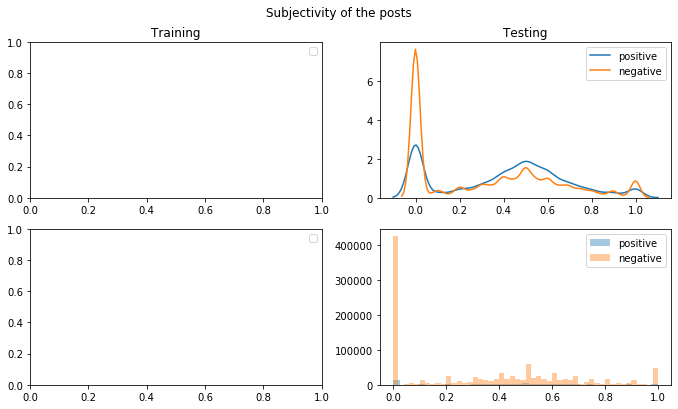

In [21]:
subjectivity_test = df_test.groupby("label").agg({"subjectivity": sum})
subjectivity_test = subjectivity_test.subjectivity.apply(lambda x: np.array(x))

fig, axis = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10, 6))
axis[0, 0].set_title("Training")
axis[0, 1].set_title("Testing")
fig.suptitle("Subjectivity of the posts")

sns.kdeplot(subjectivity_test["positive"], ax=axis[0, 1], label="positive")
sns.distplot(subjectivity_test["positive"], ax=axis[1, 1], label="positive", kde=False)
sns.kdeplot(subjectivity_test["negative"], ax=axis[0, 1], label="negative")
sns.distplot(subjectivity_test["negative"], ax=axis[1, 1], label="negative", kde=False)

for ax in axis.ravel():
    ax.legend()

plt.tight_layout(pad=2.8, w_pad=0.5, h_pad=1.0);

##  Word cloud

In [22]:
plain_test_posts = [p for _posts in df_test.posts for p in _posts]
plain_posts = plain_test_posts

In [23]:
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b[\w']+\b", use_idf=True)
vectorizer.fit(plain_posts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern="(?u)\\b[\\w']+\\b",
                tokenizer=None, use_idf=True, vocabulary=None)

In [24]:
idx2word = {idx: word for (word, idx) in vectorizer.vocabulary_.items()}

In [25]:
idf_sort_idxs = np.argsort(vectorizer.idf_)

print("Top 10 words with biggest IDF")
for i in idf_sort_idxs[:10]:
    print(f"'{idx2word[i]}': {vectorizer.idf_[i]}")

Top 10 words with biggest IDF
'the': 2.023549443832473
'to': 2.244728476319721
'a': 2.2510673781691857
'and': 2.3866481555690084
'i': 2.4005949258189543
'of': 2.5515762125693957
'is': 2.60412836838121
'in': 2.6245766888656914
'number': 2.6560737398518137
'you': 2.6763374310088706


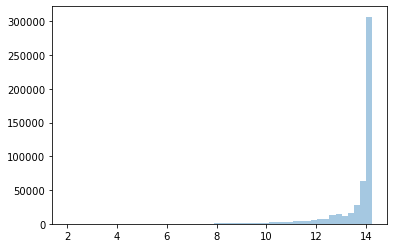

In [26]:
# Distribution of idf values throughout the dataset.
sns.distplot(vectorizer.idf_, kde=False);

In [27]:
min_percentile = 0.1
min_idf_allowed = np.percentile(vectorizer.idf_, min_percentile)

In [28]:
def get_words_in_vectorizer(posts_list):
    return [
        word
        for post in posts_list
        for word in post.split()
        if (word in vectorizer.vocabulary_)
        and (vectorizer.idf_[vectorizer.vocabulary_[word]] > min_idf_allowed)
    ]

### Testing corpus

In [29]:
users_posts = df_test.posts

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_users_posts = pool.map(get_words_in_vectorizer, users_posts)
result_users_posts = [" ".join(r) for r in result_users_posts]
result_users_posts = " ".join(result_users_posts)

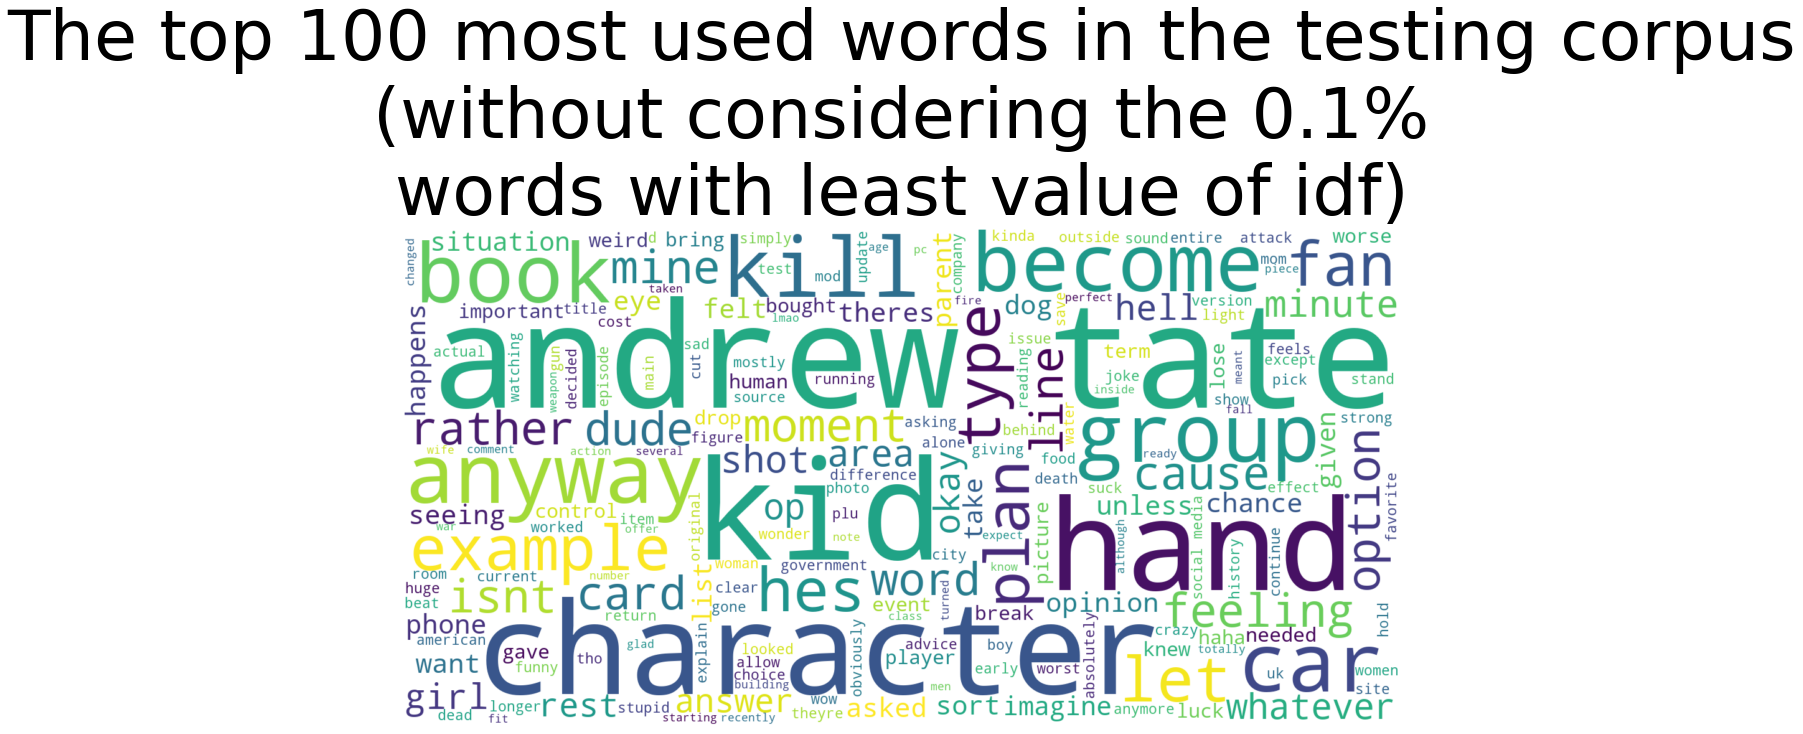

In [30]:
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(
    result_users_posts
)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the testing corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

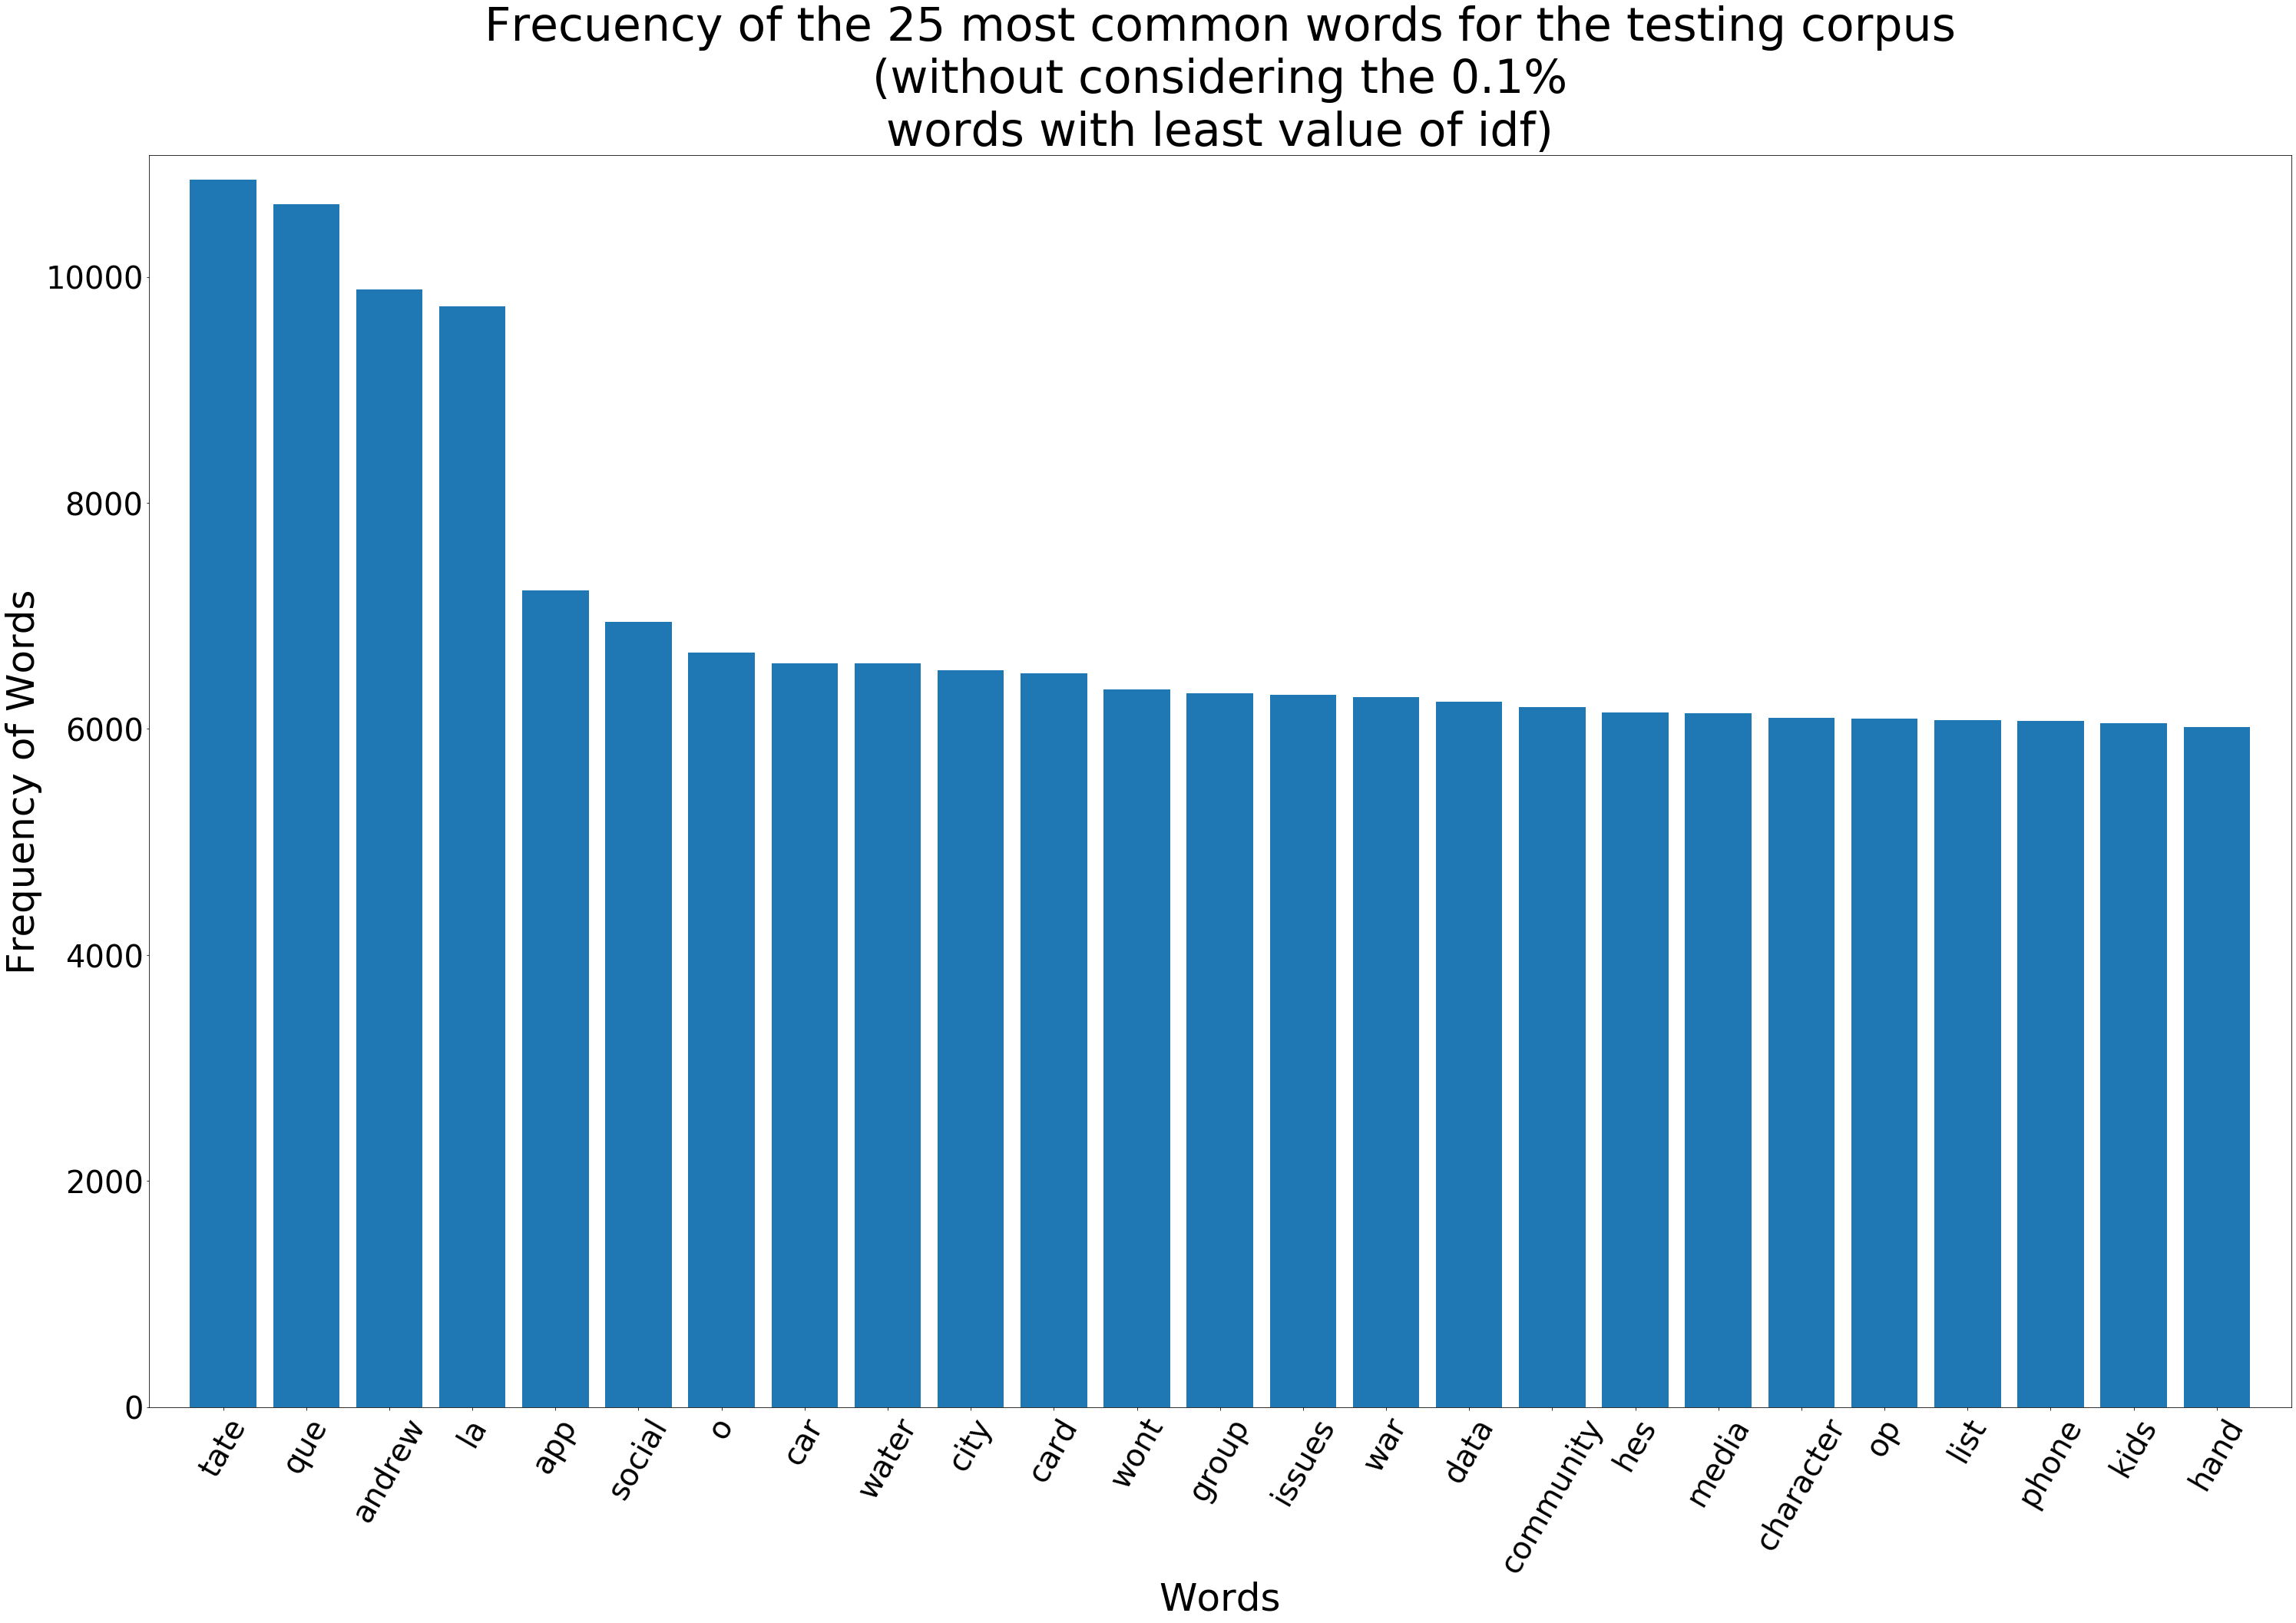

In [31]:
mostcommon_small = FreqDist(result_users_posts.split()).most_common(25)

x, y = zip(*mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\n(without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for positive users in the testing corpus

In [32]:
positive_users_posts = df_test.posts[df_test.label == "positive"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_positive_users_posts = pool.map(
        get_words_in_vectorizer, positive_users_posts
    )
result_positive_users_posts = [" ".join(r) for r in result_positive_users_posts]
result_positive_users_posts = " ".join(result_positive_users_posts)

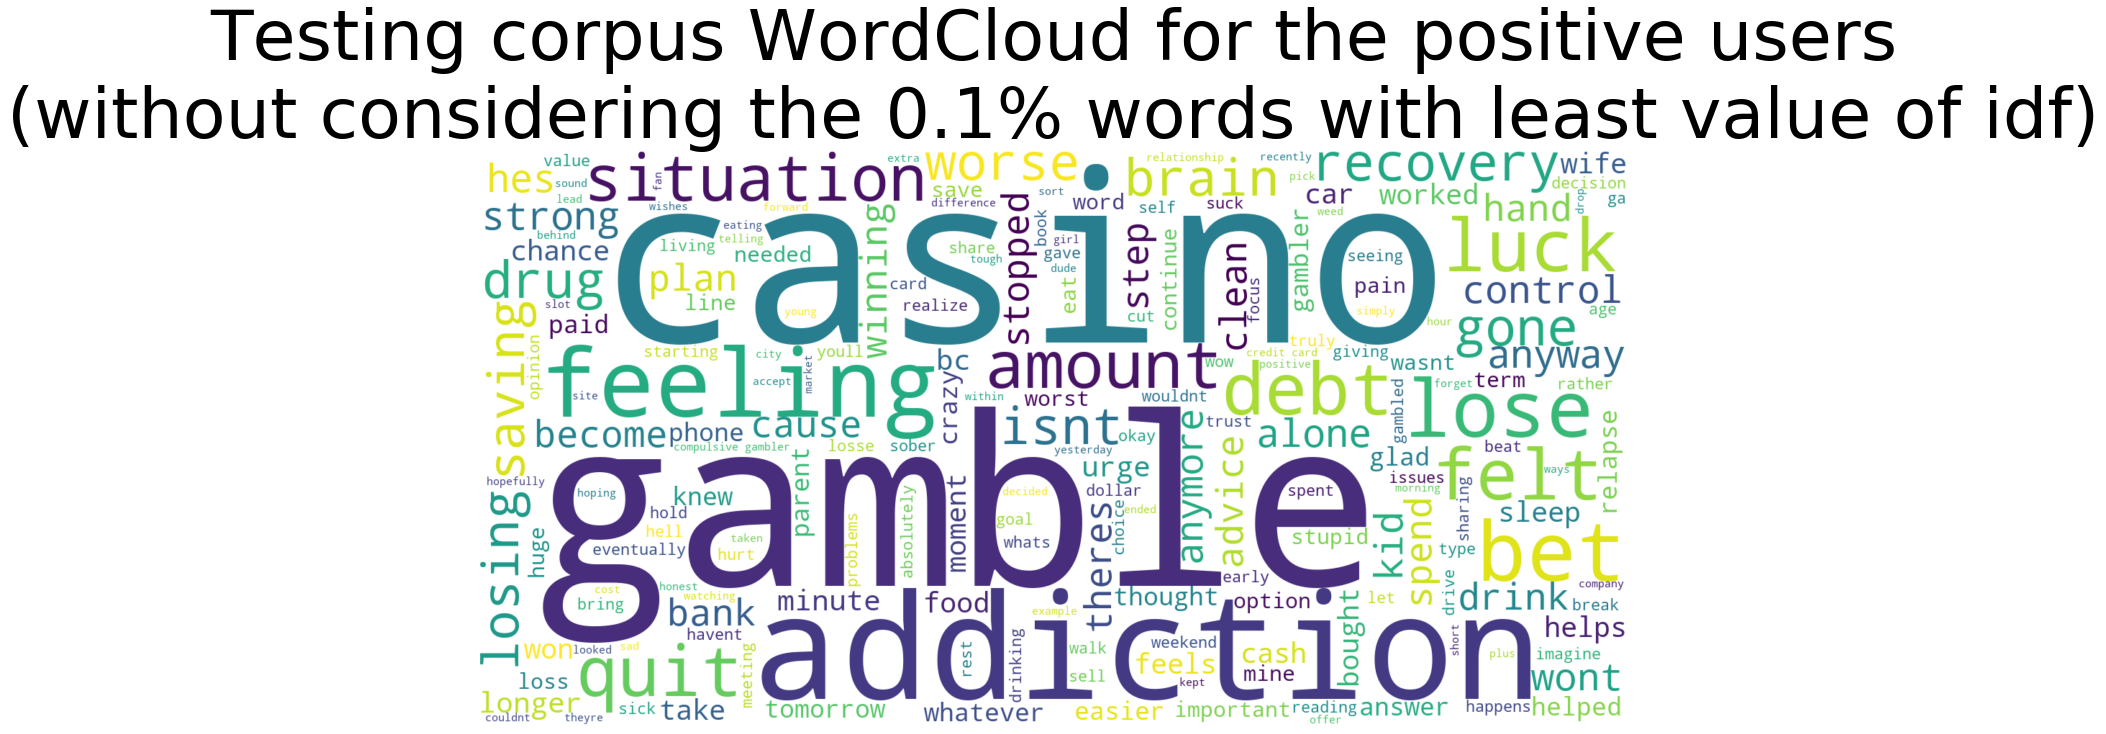

In [33]:
positive_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_positive_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "Testing corpus WordCloud for the positive users\n(without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

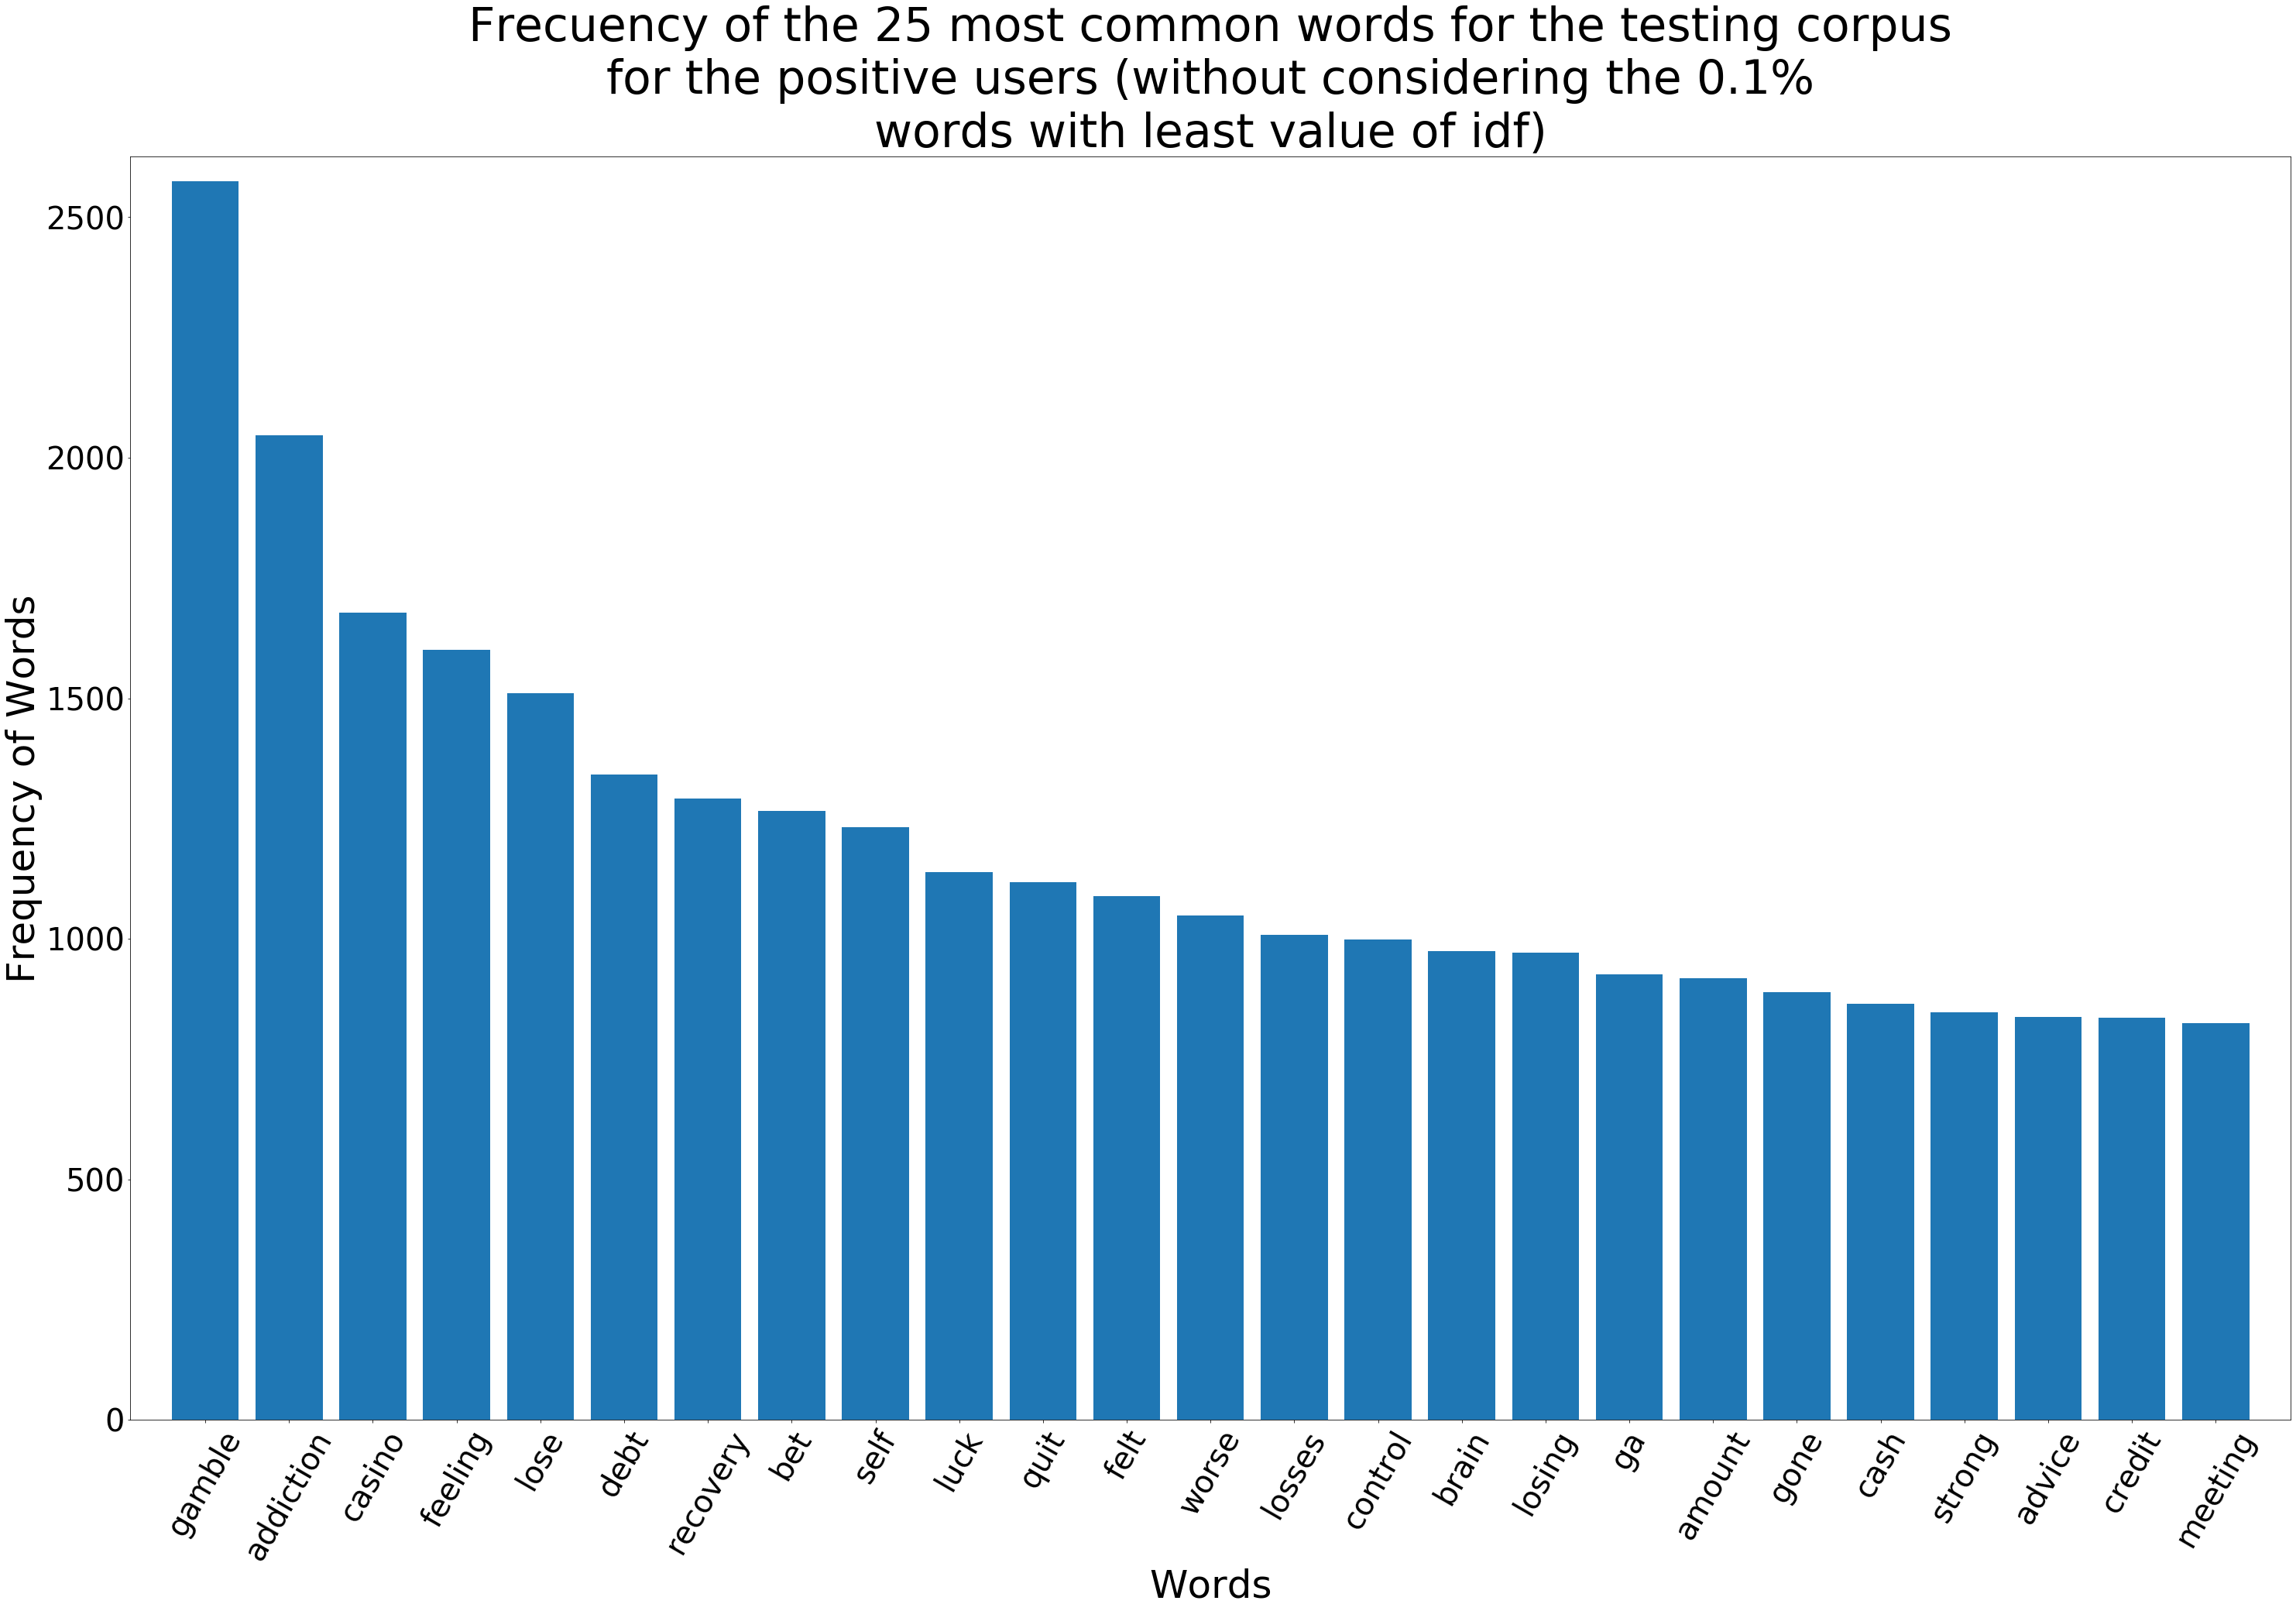

In [34]:
positive_mostcommon_small = FreqDist(result_positive_users_posts.split()).most_common(
    25
)

x, y = zip(*positive_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\nfor the positive users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=60,
)
plt.show()

### Wordcloud for negative users in the testing corpus

In [35]:
negative_users_posts = df_test.posts[df_test.label == "negative"]

with Pool(processes=NUM_SUB_PROCESSES) as pool:
    result_negative_users_posts = pool.map(
        get_words_in_vectorizer, negative_users_posts
    )
result_negative_users_posts = [" ".join(r) for r in result_negative_users_posts]
result_negative_users_posts = " ".join(result_negative_users_posts)

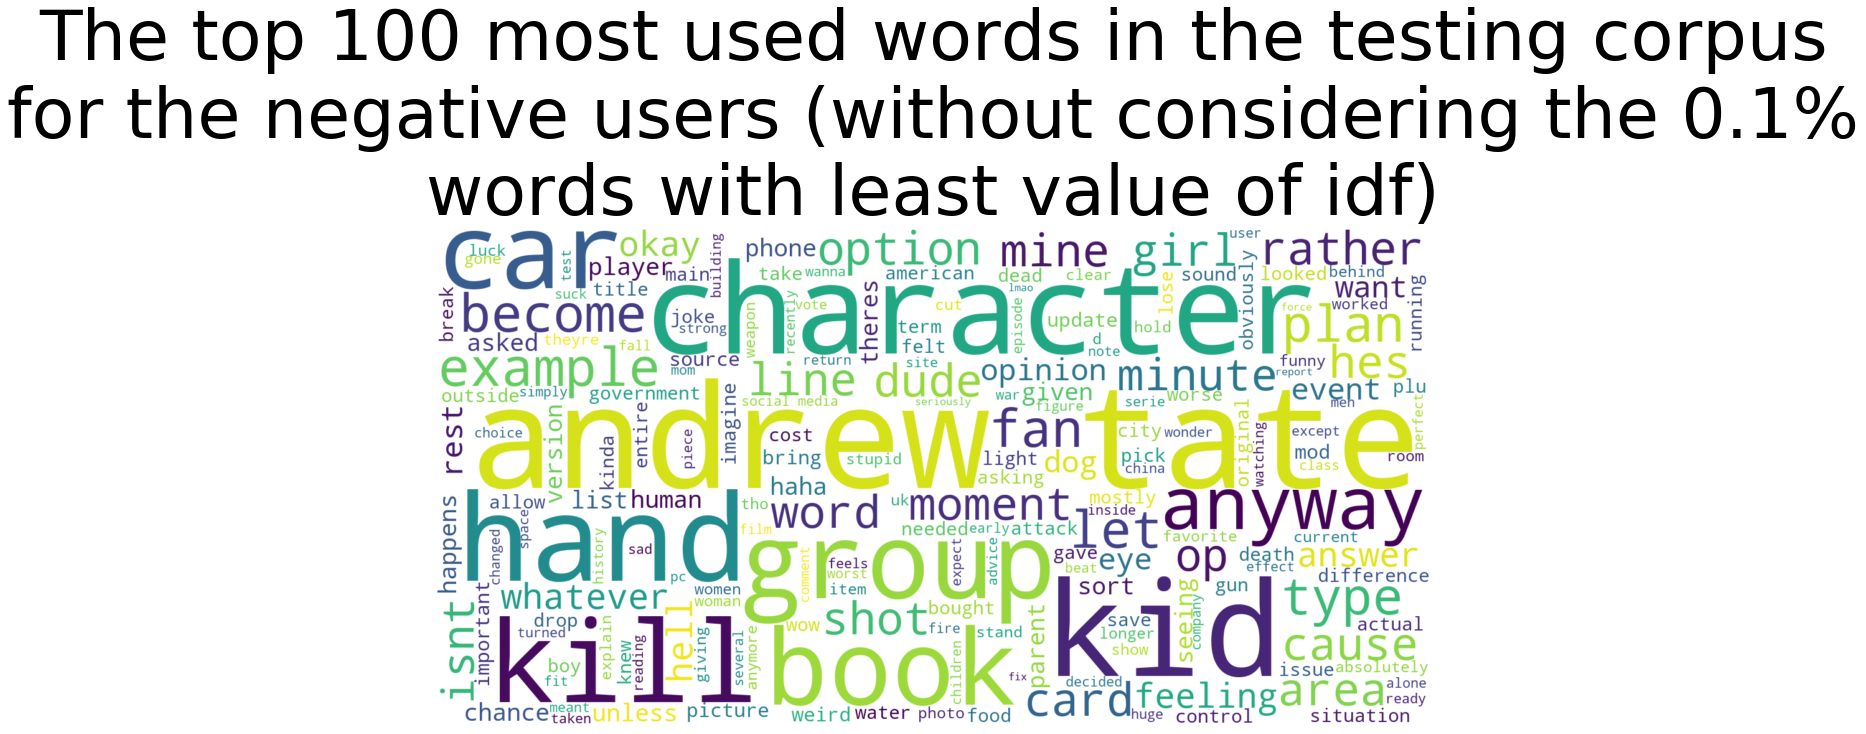

In [36]:
negative_wordcloud = WordCloud(
    width=1600, height=800, background_color="white"
).generate(result_negative_users_posts)

fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "The top 100 most used words in the testing corpus\nfor the negative users (without considering the "
    f"{min_percentile}%\nwords with least value of idf)",
    fontsize=70,
)
plt.tight_layout(pad=0)
plt.show()

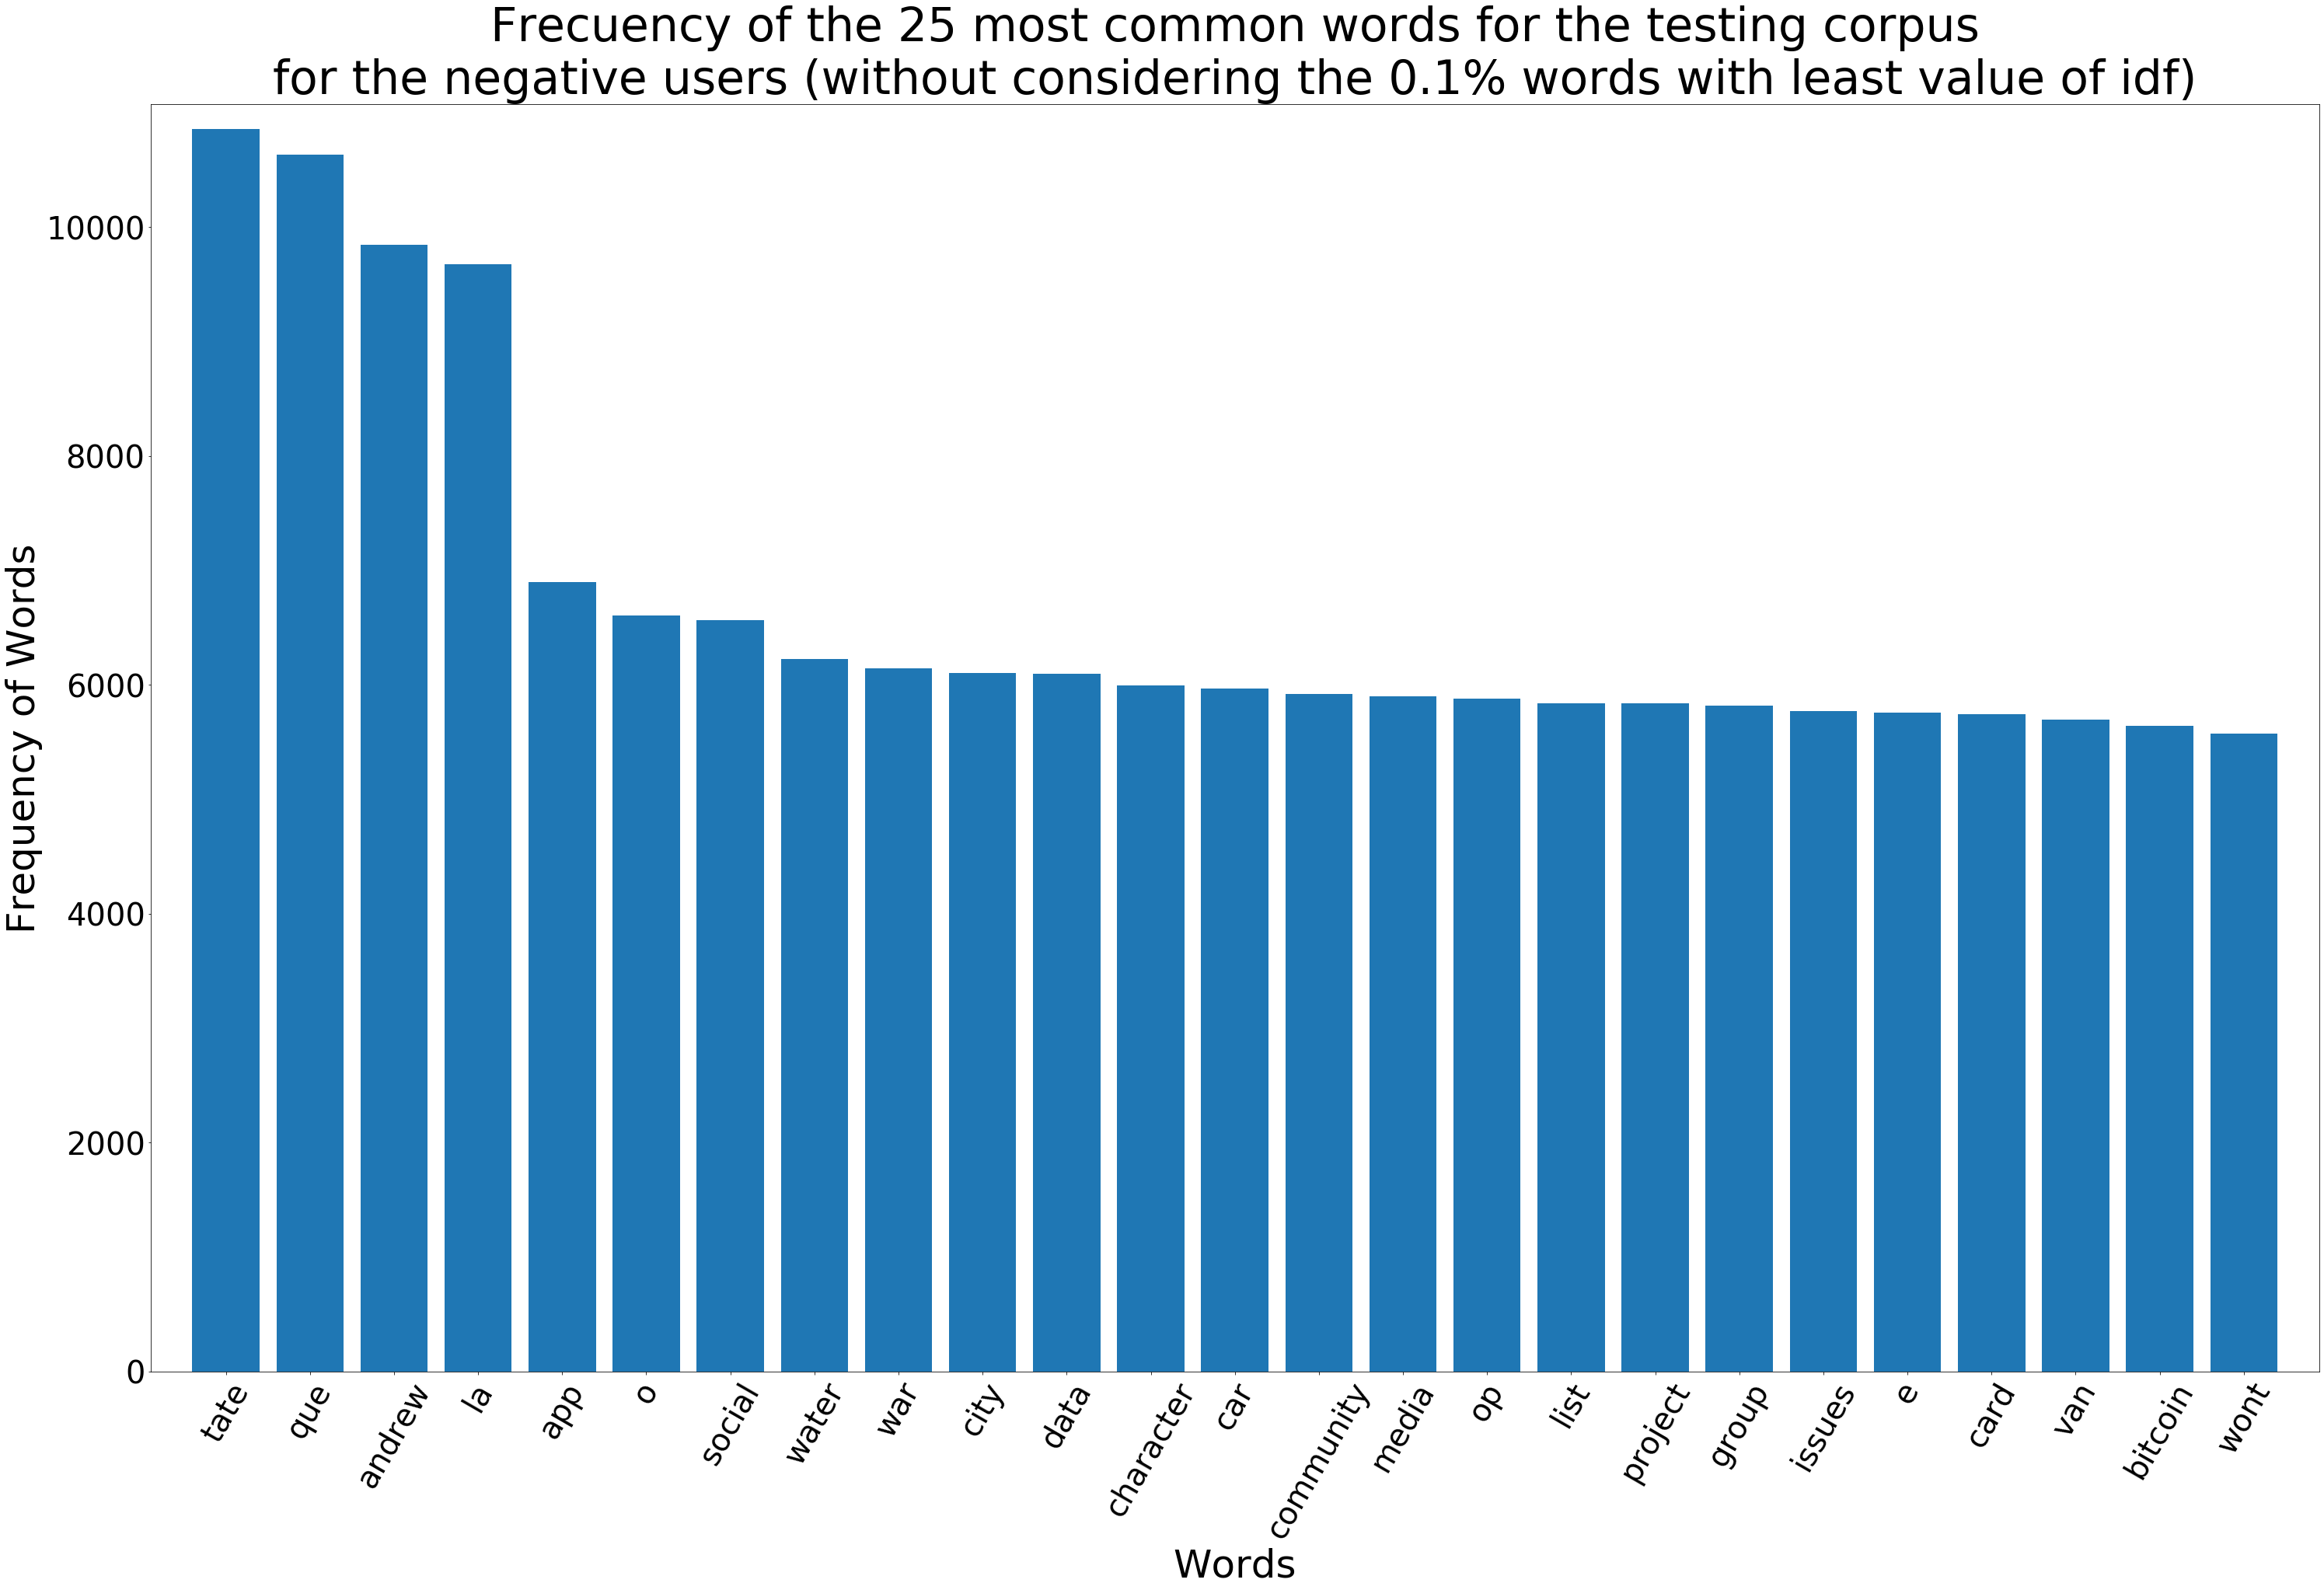

In [37]:
negative_mostcommon_small = FreqDist(result_negative_users_posts.split()).most_common(
    25
)

x, y = zip(*negative_mostcommon_small)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title(
    "Frecuency of the 25 most common words for the testing corpus\nfor the negative users (without considering the "
    f"{min_percentile}% words with least value of idf)",
    fontsize=60,
)
plt.show()